## __XDF latency analysis of LSL data streams: Unity (triggered) vs EEG (measured)__

### __Situation__ 
#### Every 500ms a beep sound is played and the background color changes one frame from black to white.

#### __Unity (90 FPS):__
- Color change (black or white background)
- Beep sound (audio playing or not)

#### __EEG (1024 Hz):__
- Photodiode (light sensor)
- Microphone (audio sensor)


#### __TODO__
* [x] Read XDF file and header and select the right data (timestamps and values)
* [x] Compute the timestamps from 0
* [x] Visualize the data: unity audio vs microphone and unity color vs photodiode
* [x] Compare the timestamps (length, duration, sample count..): Original vs Calculated vs FileInfo
* [x] Descriptive statistics of timestamps distribution and plot
* [x] Actual latency test: select the microphone and photodiode peaks (starting points) and compare with the unity ones
* [x] Test all recordings
* [x] Make and test long recordings (half an hour) and check with two computers (local network setup)
* [ ] Find out why sometimes Unity timestamps start before the EEG ones
* [ ] Find out why sometimes there are two Diode spikes during one colour change
* [ ] ...

#### __Dependencies__

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyxdf
from scipy.signal import find_peaks
import seaborn as sns

#### __Files (recordings)__

In [25]:
files = os.listdir("data")  # get all files from the folder "data"
files.sort()  # sort them alphabetically
recordings = []

for file in files:
    if file.startswith("."):  # filter hidden/config files
        files.remove(file)  # remove hidden/config file

for i, file in enumerate(files):  # store and display all files
    recordings.append(file)
    print(f"recordings[{i}] = {file}")

recordings[0] = final_test.xdf
recordings[1] = ftest1.xdf
recordings[2] = ftest2.xdf
recordings[3] = ftest3.xdf
recordings[4] = ftest_build1.xdf
recordings[5] = ftest_build2.xdf
recordings[6] = ftest_build3.xdf
recordings[7] = ftest_lsl12.xdf
recordings[8] = long2.xdf
recordings[9] = long3.xdf
recordings[10] = long4.xdf
recordings[11] = short_new.xdf
recordings[12] = short_test.xdf
recordings[13] = short_test_old1.xdf
recordings[14] = test.xdf


#### __Helper functions__

In [26]:
a_ch_name = "Audio"
c_ch_name = "Diode"
e_ch_name = "openvibeSignal"


def select_streams(data):
    global s_channels
    s_channels = {data[i]["info"]["name"][0]: i for i in range(len(data))}

    # Time values
    a = s_channels[a_ch_name]  # unity audio stream channel
    c = s_channels[c_ch_name]  # unity color stream channel
    e = s_channels[e_ch_name]  # eeg stream channel (diode and microphone)
    return a, c, e

#### __Checking if EEG data was received before Unity data for all recordings__

In [27]:
print("EEG received first (✔/✗):")
for file in recordings:  # check all files
    streams, fileheader = pyxdf.load_xdf(f"data/{file}")  # load a XDF file
    a_ch, c_ch, e_ch = select_streams(streams)  # select the data stream channels
    a_t = streams[a_ch]["time_stamps"][0]  # get the first unity timestamp
    e_t = streams[e_ch]["time_stamps"][0]  # get the first eeg timestamp
    if a_t - e_t < 0:  # unity received first (negative difference)
        print(f"✗ {file}")
    else:  # eeg received first (positive difference)
        print(f"✔ {file}")

EEG received first (✔/✗):
✔ final_test.xdf
✔ ftest1.xdf
✔ ftest2.xdf
✔ ftest3.xdf
✔ ftest_build1.xdf
✔ ftest_build2.xdf
✔ ftest_build3.xdf
✔ ftest_lsl12.xdf
✔ long2.xdf
✗ long3.xdf
✔ long4.xdf
✗ short_new.xdf
✔ short_test.xdf
✔ short_test_old1.xdf
✔ test.xdf


#### __Read XDF data__

In [28]:
file = recordings[11]  # select a file
print(f"File: {file}")  # display the file name
streams, fileheader = pyxdf.load_xdf(f"data/{file}")  # load the XDF file
fileheader  # just a dict describing the version and format of the XDF file

File: short_new.xdf


{'info': defaultdict(list, {'version': ['1.0']})}

#### __Automatically select the stream channels__

In [29]:
a_ch, c_ch, e_ch = select_streams(streams)
s_channels

{'openvibeSignal': 0, 'Audio': 1, 'Diode': 2}

#### __Read EEG and Unity timestamps and sensor data__

In [30]:
u_ts = streams[a_ch]["time_stamps"]  # unity timestamps
e_ts = streams[e_ch]["time_stamps"]  # eeg timestamps

# Diode values
eeg = np.transpose(streams[e_ch]["time_series"])

# select the photodiode and microphone sensor information
# there's recordings with diode data on channels 65 and 66
# so we check which is the right one for this recording
if max(eeg[64]) != 0.0:
    e_color = eeg[64]  # channel 65 of the ANT amplifier
else:
    e_color = eeg[65]  # channel 66 of the ANT amplifier

e_audio = eeg[69]  # channel 70 of the ANT amplifier

# select unity audio and background color change markers
# format: [currentFrame, value, timestamp]
u_color = np.transpose(streams[c_ch]["time_series"])
u_audio = np.transpose(streams[a_ch]["time_series"])

e_color = -e_color  # invert diode data polarity, easier to visualize

#### __Preprocess data: calculate meaningful timestamps__

In [31]:
# calculate time values for unity and eeg from 0
e_time = [0]
length = len(e_ts)
[e_time.append(e_ts[i + 1] - e_ts[0]) for i in range(length) if i < length - 1]

u_time = [0]
length = len(u_ts)
[u_time.append(u_ts[i + 1] - u_ts[0]) for i in range(length) if i < length - 1]

# calculate the diff and shift the values left (negative) or right (positive)
diff = u_ts[0] - e_ts[0]
u_time = [i + diff for i in u_time]

# if diff is negative unity data was received before eeg
if diff < 0:
    print("Unity data received first ✗")
    if diff < -0.98: #so if the difference cannot be explained by normal EEG sampling
        print("Something went wrong with this recording")
else:
    print("EEG data received first ✔")

Unity data received first ✗


#### __Data preview__

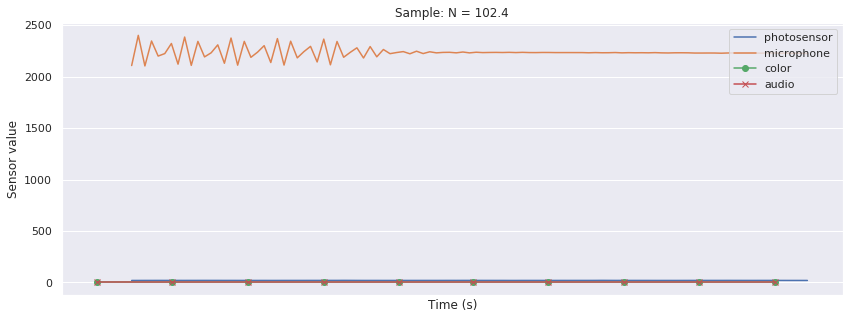

In [68]:
# interactive: widget, not interactive: inline
%matplotlib inline 
sns.set(rc={"figure.figsize": (14, 5)})  # set figure size
sns.set_style("darkgrid")  # set seaborn plotting style

f_n = -0.2  # starting point (s)
s_n = 0.1 # ending point (s)

start_e = 1024 * f_n  # eeg sampling rate = 1024
start_u = 90 * f_n  # unity sampling rate = 90

five_sec = 1024 * s_n  # N of eeg in 5 s
f_sec = 90 * s_n  # N of unity in 5 s
u_height = 3500  # factor to improve unity (true/1) values visualization
e_t = np.array(e_time)
u_t = np.array(u_time)

# select range of timestamps, diode and microphone values (eeg)
e_time_selection = e_t[(e_t > f_n) & (e_t < s_n)]
e_color_selection = e_color[(e_t > f_n) & (e_t < s_n)]
e_audio_selection = e_audio[(e_t > f_n) & (e_t < s_n)]

# select a range of timestamps, color and audio values (unity)
u_time_selection = u_t[(u_t > f_n) & (u_t < s_n)]
u_color_selection = u_color[(u_t > f_n) & (u_t < s_n)]
u_audio_selection = u_audio[1][(u_t > f_n) & (u_t < s_n)]

# plot the selected range to compare eeg vs unity values
plt.plot(e_time_selection, e_color_selection * 0.05)
plt.plot(e_time_selection, e_audio_selection)
plt.plot(u_time_selection, u_color_selection * u_height, marker="o")
plt.plot(u_time_selection, u_audio_selection * u_height, marker="x")

plt.title(f"Sample: N = {five_sec}")
plt.ylabel("Sensor value")
plt.xlabel("Time (s)")
plt.xticks(np.arange(f_n, s_n, step=0.5))
labels = ["photosensor", "microphone", "color", "audio"]
plt.legend(labels, loc="upper right")  # set the legend
plt.show()

#### __Timestamps comparison (original vs computed vs file info)__

In [69]:
# store unity and eeg timestamps as pandas series
# dataframe is not needed since it's 1D array

eeg_t = pd.Series(streams[e_ch]["time_stamps"])
unity_t = pd.Series(streams[a_ch]["time_stamps"])

print("Original timestamps")
print("===================")
u_start = u_ts[0]
u_end = u_ts[-1]
e_start = e_ts[0]
e_end = e_ts[-1]
u_length = u_end - u_start
e_length = e_end - e_start
print(f"EEG first timestamp: {e_start}")
print(f"EEG last timestamp: {e_end}")
print(f"EEG length: {e_length}")
print(f"EEG sample count: {len(e_ts)}")
print(f"Unity first timestamp: {u_start}")
print(f"Unity last timestamp: {u_end}")
print(f"Unity length: {u_length}")
print(f"Unity sample count: {len(u_ts)}")
print(f"Start difference: {abs(u_start - e_start)}")
print(f"Length difference: {abs(u_length - e_length)}")

print("")

print("Computed timestamps")
print("====================")
u_start = u_time[0]
# [-1:] returns the index and the type as well but [-1:].values[0] also works
u_end = u_time[-1]
e_start = e_time[0]
e_end = e_time[-1]
u_length = u_end - u_start
e_length = e_end - e_start
print(f"EEG first timestamp: {e_start}")
print(f"EEG last timestamp: {e_end}")
print(f"EEG length: {e_length}")
print(f"EEG sample count: {len(e_time)}")
print(f"Unity first timestamp: {u_start}")
print(f"Unity last timestamp: {u_end}")
print(f"Unity length: {u_length}")
print(f"Unity sample count: {len(u_time)}")
print(f"Start difference: {abs(u_start - e_start)}")
print(f"Length difference: {abs(u_length - e_length)}")

print("")

print("File info")
print("========")
e_info = streams[e_ch]["info"]
e_footer = streams[e_ch]["footer"]["info"]
u_info = streams[a_ch]["info"]
u_footer = streams[a_ch]["footer"]["info"]

print(f"EEG stream created at: {e_info['created_at'][0]}")
print(f"Unity stream created at: {u_info['created_at'][0]}")
print(f"EEG first timestamp: {e_footer['first_timestamp'][0]}")
print(f"EEG last timestamp: {e_footer['last_timestamp'][0]}")
print(f"EEG sample count: {e_footer['sample_count'][0]}")
print(f"Unity first timestamp: {u_footer['first_timestamp'][0]}")
print(f"Unity last timestamp: {u_footer['last_timestamp'][0]}")
print(f"Unity sample count: {u_footer['sample_count'][0]}")

Original timestamps
EEG first timestamp: 2896.829572491063
EEG last timestamp: 2961.329951709267
EEG length: 64.50037921820376
EEG sample count: 66048
Unity first timestamp: 2896.824495070672
Unity last timestamp: 2961.3178294674435
Unity length: 64.49333439677139
Unity sample count: 5806
Start difference: 0.005077420390989573
Length difference: 0.007044821432373283

Computed timestamps
EEG first timestamp: 0
EEG last timestamp: 64.50037921820376
EEG length: 64.50037921820376
EEG sample count: 66048
Unity first timestamp: -0.005077420390989573
Unity last timestamp: 64.4882569763804
Unity length: 64.49333439677139
Unity sample count: 5806
Start difference: 0.005077420390989573
Length difference: 0.007044821432373283

File info
EEG stream created at: 2865.822203900000
Unity stream created at: 74999.42783250001
EEG first timestamp: 2896.8412703
EEG last timestamp: 2961.3132359
EEG sample count: 66047
Unity first timestamp: 75012.3227705
Unity last timestamp: 75076.8157208
Unity sample cou

#### __Descriptive statistics: EEG timestamps__

In [70]:
e_time_dist = [e_ts[i + 1] - e_ts[i] for i in range(len(e_ts) - 1)]
u_time_dist = [u_ts[i + 1] - u_ts[i] for i in range(len(u_ts) - 1)]

e_time_dist = pd.DataFrame(np.array(e_time_dist), columns=["eeg"])
u_time_dist = pd.DataFrame(np.array(u_time_dist), columns=["unity"])

e_time_dist.describe()

,eeg
count,6.604700e+04
mean,9.765830e-04
std,2.271974e-13
min,9.765830e-04
25%,9.765830e-04
50%,9.765830e-04
75%,9.765830e-04
max,9.765830e-04


The EEG samples look really constant over time

#### __Descriptive statistics: Unity timestamps__

In [71]:
u_time_dist.describe()

,unity
count,5805.000000
mean,0.011110
std,0.000864
min,0.000025
25%,0.011064
50%,0.011107
75%,0.011150
max,0.022229


It does not seem the case for the unity samples
#### __Time sampling plot comparison__

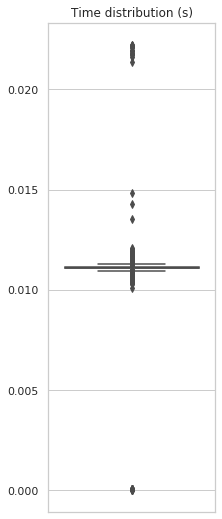

In [72]:
%matplotlib inline
sns.set(rc={"figure.figsize": (3, 9)})  # set figure size
sns.set_style("whitegrid")  # set seaborn plotting style
p = sns.boxplot(x=u_time_dist, orient="v")
p.set_title("Time distribution (s)")
plt.show()

#### __Calculating the Latencies__

###### __Diode__

In [88]:
# get all the first peaks of each of the four recordings
e_col_peaks = find_peaks(e_color, height=10000, distance=400)
# here the len of unity is one longer than the len of
u_col_peaks = find_peaks(u_color)

# since we are only intersted in the position of the peaks not the height, lets only take the first column
ec_peak = e_col_peaks[0]
uc_peak = u_col_peaks[0]

# now we have the column where the peak occurs, now we need the corresponding time stamp
ec_time = [e_time[e] for e in ec_peak]
uc_time = [u_time[e] for e in uc_peak]

# calculate the differneces between EEG and unity
c_diff = np.empty(len(uc_time))
c_diff[:] = np.nan
c_diff = []
length = len(uc_time)
# to make sure we do not start with j = 0 if EEG starts before Unity
if np.array(uc_time)[0] > 0.25:
    j = 1
else:
    j = 0

for i in range(length):
    if (uc_time[i] - ec_time[j] > -0.25) and (uc_time[i] - ec_time[j] < 0):
        # add the difference between EEG and unity peak
        c_diff.append(uc_time[i] - ec_time[j])
        if j < len(ec_time):
            j = j + 1
    else:
        # add nan if there is no EEG peak
        c_diff.append(np.nan)

# check the nan values (and compare them to the graph)
nan_val = []
# get the indices of all nan values so we can check if there a diode is actually missing
nan_val.append(np.argwhere(np.isnan(c_diff)))
n = np.ravel(nan_val)  # to make it look nicer
# contains the untiy timestamps when the diode is missing --> to check in graph
time_st = np.array(uc_time)[np.array(n)]
print(time_st)

[0.36199287]


###### __Speaker__

In [93]:
# get all the first peaks of each of the four recordings
e_audio_peaks = find_peaks(e_audio, height=2100, distance=400)
# here the len of unity is one longer than the len of
u_audio_peaks = find_peaks(u_audio[1])

# since we are only intersted in the position of the peaks not the height, lets only take the first column
ea_peak = e_audio_peaks[0]
ua_peak = u_audio_peaks[0]

# now we have the column where the peak occurs, now we need the corresponding time stamp
ea_time = [e_time[e] for e in ea_peak]
ua_time = [u_time[e] for e in ua_peak]

# calculate the differneces between EEG and unity
a_diff = []
length = len(ua_time)
# to make sure we do not start with j = 0 if EEG starts before Unity
if np.array(uc_time)[0] > 0.25:
    j = 1
else:
    j = 0
for i in range(length):
    if (ua_time[i] - ea_time[j] > -0.3) and (ua_time[i] - ea_time[j] < 0):
        # print(uc_time[i] - ec_time[j])
        a_diff.append(ua_time[i] - ea_time[j])
        if j < len(ea_time):
            j = j + 1
    else:
        a_diff.append(np.nan)

nan_val = []
# get the indices of all nan values so we can check if there a diode is actually missing
nan_val.append(np.argwhere(np.isnan(a_diff)))
n = np.ravel(nan_val)  # to make it look nicer
time_st = np.array(ua_time)[np.array(n)]  # contains the untiy timestamps when the diode is missing --> to check in graph
print(time_st)

[]


#### __Data Preview__ 

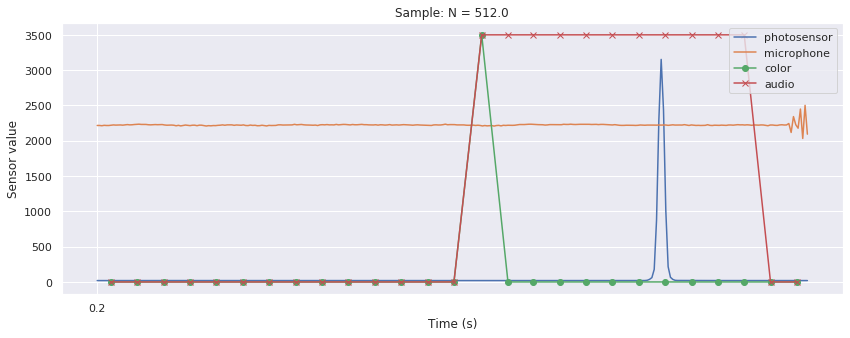

In [94]:
# interactive: widget, not interactive: inline
%matplotlib inline 
sns.set(rc={"figure.figsize": (14, 5)})  # set figure size
sns.set_style("darkgrid")  # set seaborn plotting style

f_n = 0.2  # starting point (s)
s_n = 0.5 # ending point (s)

start_e = 1024 * f_n  # eeg sampling rate = 1024
start_u = 90 * f_n  # unity sampling rate = 90

five_sec = 1024 * s_n  # N of eeg in 5 s
f_sec = 90 * s_n  # N of unity in 5 s
u_height = 3500  # factor to improve unity (true/1) values visualization
e_t = np.array(e_time)
u_t = np.array(u_time)

# select range of timestamps, diode and microphone values (eeg)
e_time_selection = e_t[(e_t > f_n) & (e_t < s_n)]
e_color_selection = e_color[(e_t > f_n) & (e_t < s_n)]
e_audio_selection = e_audio[(e_t > f_n) & (e_t < s_n)]

# select a range of timestamps, color and audio values (unity)
u_time_selection = u_t[(u_t > f_n) & (u_t < s_n)]
u_color_selection = u_color[(u_t > f_n) & (u_t < s_n)]
u_audio_selection = u_audio[1][(u_t > f_n) & (u_t < s_n)]

# plot the selected range to compare eeg vs unity values
plt.plot(e_time_selection, e_color_selection * 0.05)
plt.plot(e_time_selection, e_audio_selection)
plt.plot(u_time_selection, u_color_selection * u_height, marker="o")
plt.plot(u_time_selection, u_audio_selection * u_height, marker="x")

plt.title(f"Sample: N = {five_sec}")
plt.ylabel("Sensor value")
plt.xlabel("Time (s)")
plt.xticks(np.arange(f_n, s_n, step=0.5))
labels = ["photosensor", "microphone", "color", "audio"]
plt.legend(labels, loc="upper right")  # set the legend
plt.show()

#### __Descriptive Statistics__ 

In [95]:
# Descriptive Statistics of colour peak diff
c_diff_data = pd.DataFrame(c_diff)
c_diff_data.describe()

,0
count,125.000000
mean,-0.076154
std,0.000287
min,-0.076698
25%,-0.076376
50%,-0.076160
75%,-0.075914
max,-0.075392


* ftest1:       -0.080 till -0.073
* ftest2:       -0.078 till -0.073
* ftest3:       -0.080 till -0.074
* test:         -0.100 till -0.072
* ftest_build1: -0.077 till -0.074
* ftest_build2: -0.080 till -0.074
* ftest_build3: -0.080 till -0.074
* ftest_lsl12:  -
* final test:   -0.076 till -0.074

In [96]:
# Descriptive Statistics of audio peak diff
a_diff_data = pd.DataFrame(a_diff)
a_diff_data.describe()

,0
count,126.000000
mean,-0.083747
std,0.005148
min,-0.095069
25%,-0.087618
50%,-0.084059
75%,-0.080443
max,-0.072324
